In [1]:
import numpy as np
import cv2
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Function to load and preprocess images for the CNN
def load_cnn_data(directory_path, image_size=(64, 64)):
    images, labels = [], []
    data_dir = Path(directory_path)
    for label_folder in tqdm(sorted(data_dir.iterdir()), desc="Loading CNN Data"):
        if label_folder.is_dir():
            for img_path in label_folder.glob('*.jpg'):
                image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(cv2.resize(image, image_size))
                    labels.append(label_folder.name)
    
    images = np.array(images, dtype="float32") / 255.0
    images = np.expand_dims(images, -1)
    return images, np.array(labels)

print("Functions defined.")

Functions defined.


In [5]:
DATA_DIR = 'processed_for_cnn'
X_cnn, y_cnn = load_cnn_data(DATA_DIR)

# Encode labels
label_encoder_cnn = LabelEncoder()
y_cnn_encoded = label_encoder_cnn.fit_transform(y_cnn)
num_classes = len(label_encoder_cnn.classes_)

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42, stratify=y_cnn_encoded)

print(f"\nData ready for CNN. Training samples: {len(X_train_cnn)}, Test samples: {len(X_test_cnn)}")

Loading CNN Data: 100%|██████████| 26/26 [00:00<00:00, 220.49it/s]


Data ready for CNN. Training samples: 696, Test samples: 174


In [6]:
# Here we define the layers of our CNN
model = keras.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 64, 64, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │       326,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,986 (1.32 MB)

 Trainable params: 344,986 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
print("\n--- Starting CNN Training ---")
history = model.fit(
    X_train_cnn, y_train_cnn, 
    epochs=25,  # Train for more epochs as CNNs are more complex
    batch_size=32, 
    validation_data=(X_test_cnn, y_test_cnn)
)


--- Starting CNN Training ---
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0608 - loss: 3.2750 - val_accuracy: 0.0920 - val_loss: 3.1541
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0906 - loss: 3.1819 - val_accuracy: 0.0920 - val_loss: 3.0398
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1102 - loss: 3.0238 - val_accuracy: 0.2184 - val_loss: 2.6732
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2062 - loss: 2.7388 - val_accuracy: 0.5517 - val_loss: 1.9724
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4050 - loss: 2.1612 - val_accuracy: 0.6552 - val_loss: 1.4306
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4994 - loss: 1.6985 - val_accuracy: 0.8333 - val_loss: 1.0292
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6550 - loss: 1.3113 - val_accuracy: 0.7299 - val_loss: 0.9832
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6861 - loss: 1.


--- CNN Model Evaluation ---
Final Test Accuracy: 95.98%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         7
          aa       1.00      1.00      1.00         7
          be       1.00      0.86      0.92         7
         che       1.00      1.00      1.00         9
        chee       0.94      1.00      0.97        16
          fe       0.78      1.00      0.88         7
          ge       1.00      1.00      1.00         3
         haa       1.00      0.86      0.92         7
        haaa       1.00      0.90      0.95        10
          ke       1.00      1.00      1.00         4
         kgn       1.00      1.00      1.00         3
          le       0.88      1.00      0.93         7
          me       1.00      0.80      0.89         5
         pee       1.00      1.00      1.00         7
          qe       1.00      1.00      1.00         6
          re   

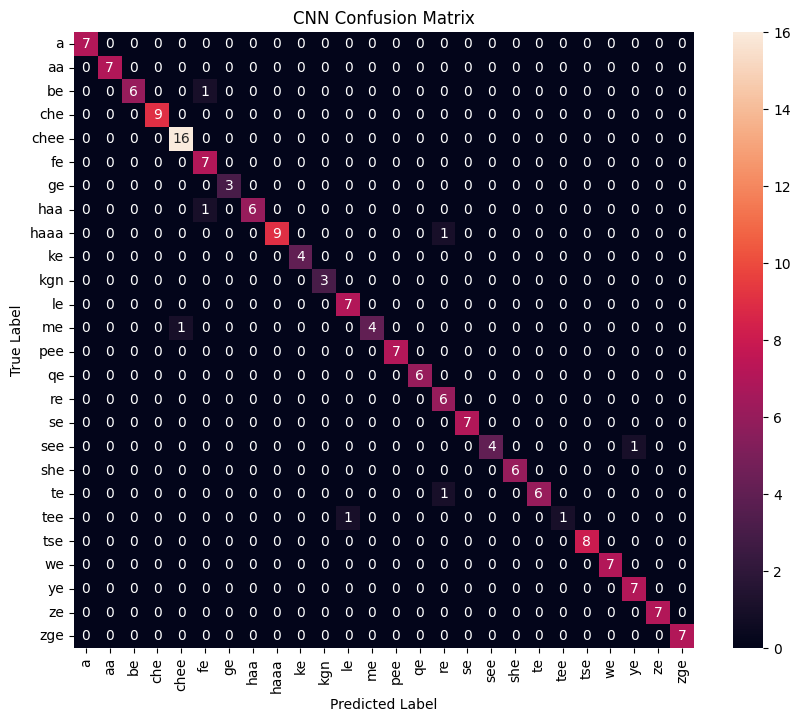

In [8]:
print("\n--- CNN Model Evaluation ---")
loss, accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

# Generate report and confusion matrix
y_pred_cnn_probs = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_cnn, y_pred_cnn, target_names=label_encoder_cnn.classes_))

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=label_encoder_cnn.classes_, yticklabels=label_encoder_cnn.classes_)
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
model.save('cnn_model.keras')
with open('label_encoder_cnn.pkl', 'wb') as f:
    pickle.dump(label_encoder_cnn, f)
    
print("CNN model and encoder saved.")

CNN model and encoder saved.
